### Univariate Interpolation ###

The following table summarizes the different univariate interpolation modes coded in `scipy`, together with the processes we may use to resolve them:


| Interpolation Mode  | Object-oriented implementation | Procedural implementation |
|---------------------|--------------------------------|---------------------------|
| Nearest-neighbors   | `interp1d( ,kind='nearest')`   |                           |
| Lagrange Polynomial | `BarycentricInterpolator`      | `barycentric_interpolate` |
| Hermite Polynomial  | `KroghInterpolator`            | `krogh_interpolate`       |
| Generic Piecewise Polynomial  | `PiecewisePolynomial` | `piecewise_polynomial_interpolate` |
| Piecewise Linear | `interp1d( ,kind='linear')` | |
| Generic Spline Interpolation | `InterpolatedUnivariateSpline` | `splrep` |
| Zero-order Spline | `interp1d( ,kind='zero')` | |
| Linear Spline | `interp1d( ,kind='slinear')` | |
| Quadratic Spline with maximum smoothness | `interp1d( ,kind='quadratic')` | |
| Cubic Spline with maximum smoothness | `interp1d( ,kind='cubic')` | |
| Piecewise Cubic Hermite Interpolation Polynomial | `PchipInterpolator` | `pchip_interpolate`  |

#### Nearest-neighbors Interpolation ####

In the context of one-dimensional functions, *nearest-neighbors interpolation* provides a solution which is constant around each node, on each subinterval defined by two consecutive midpoints of the node set.  To calculate the required interpolants, we call the generic function `scipy.interpolate.interp1d` with the option `kind='nearest'`.  It produces an instance of the class `_Interpolator1D` with only the evaluation method available.

The following example shows its result on a simple trigonometric function $f(x) = \sin(3x)$ on the interval from 0 to 1:

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline

In [37]:
nodes = np.linspace(0, 1, 5)
print nodes

[ 0.    0.25  0.5   0.75  1.  ]


In [38]:
def f(t): return np.sin(3*t)

In [39]:
x = np.linspace(0, 1, 100)                    # the domain

In [40]:
interpolant = interp1d(nodes, f(nodes), kind='nearest')

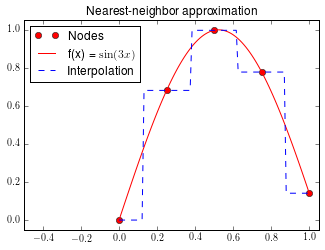

In [58]:
plt.rc('text', usetex=True)
plt.figure(figsize=(15,3.75))

plt.axes().set_aspect('equal')
plt.plot(nodes, f(nodes), 'ro', label='Nodes')
plt.plot(x, f(x), 'r-', label=r'f(x) = \sin(3x)')
plt.plot(x, interpolant(x), 'b--', label='Interpolation')
plt.title("Nearest-neighbor approximation")
plt.legend(loc=2)
plt.ylim(-0.05, 1.05)
plt.xlim(-0.5, 1.05)

plt.show()

#### Lagrange Interpolation ####

In *Lagrange interpolation* we seek a polynomial that agrees with a target function at the set of nodes.  In the module `scipy.interpolate` we have three ways to solve this problem: 

* The subclass of `_Interpolator1D`, `scipy.interpolate.BarycentricInterpolator`, that implements a very stable algorithm based upon approximation by rational functions.  This class has an evaluation method, plus two methods to add/update nodes of the fly: `.add_xi` and `.set_yi`.
* A procedural scheme, `scipy.interpolate.barycentric_interpolate`: this is syntactic sugar for the previous class, with the evaluation method applied on a prescribed domain.
* A numerically unstable functional scheme, `scipy.interpolate.lagrange`, that computes a `numpy.poly1d` instance of the interpolating polynomial.   If the nodes are few and wisely chosen, this method allows us to deal with derivative, integration and root solving problems associated with the target function, somewhat reliably.

Let us experiment with this interpolation mode on the infamous *Runge's example*: Find an interpolation polynomial for the function $f(x) = 1/(1+x^2)$ in the interval from -5 to 5, with two sets of equally distributed nodes.


In [59]:
from scipy.interpolate import BarycentricInterpolator, barycentric_interpolate, lagrange

nodes =  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
newnodes =  [-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


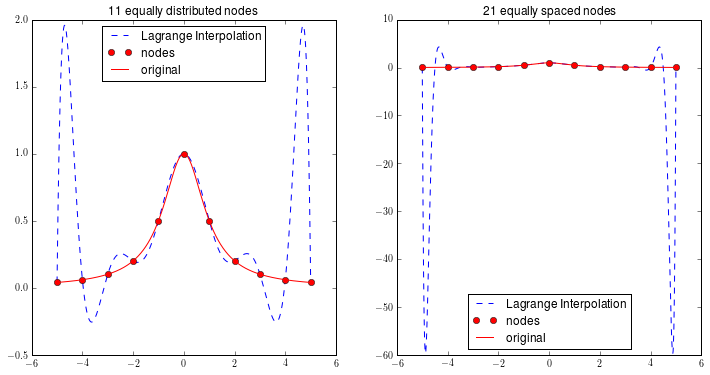

In [84]:
def f(t): return 1. / (1 + t**2)
x = np.linspace(-5,5,1000)
nodes = np.linspace(-5, 5, 11)
interpolant = BarycentricInterpolator(nodes, f(nodes))

plt.figure(figsize=(12,6))

plt.subplot(121, aspect='auto')
plt.plot(x, interpolant(x), 'b--', label="Lagrange Interpolation")
plt.plot(nodes, f(nodes), 'ro', label='nodes')
plt.plot(x, f(x), 'r-', label="original")
plt.legend(loc=9)
plt.title("11 equally distributed nodes")

newnodes = np.linspace(-4.5, 4.5, 10)
print 'nodes = ', nodes
print 'newnodes = ', newnodes

interpolant.add_xi(newnodes, f(newnodes))

plt.subplot(122, aspect='auto')
plt.plot(x, interpolant(x), 'b--', label="Lagrange Interpolation")
plt.plot(nodes, f(nodes), 'ro', label='nodes')
plt.plot(x, f(x), 'r-', label="original")
plt.legend(loc=8)
plt.title("21 equally spaced nodes")
plt.show()

Of course, the same methods to initialize our interpolants can be called to request information about them.   The following short session illustrates this point:

In [85]:
print interpolant.xi

[-5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.  -4.5 -3.5 -2.5 -1.5
 -0.5  0.5  1.5  2.5  3.5  4.5]


In [86]:
print interpolant.yi

[[ 0.03846154]
 [ 0.05882353]
 [ 0.1       ]
 [ 0.2       ]
 [ 0.5       ]
 [ 1.        ]
 [ 0.5       ]
 [ 0.2       ]
 [ 0.1       ]
 [ 0.05882353]
 [ 0.03846154]
 [ 0.04705882]
 [ 0.0754717 ]
 [ 0.13793103]
 [ 0.30769231]
 [ 0.8       ]
 [ 0.8       ]
 [ 0.30769231]
 [ 0.13793103]
 [ 0.0754717 ]
 [ 0.04705882]]


The procedural scheme has a simpler syntax, but lacks the flexibility to update nodes on the fly:


In [87]:
y = barycentric_interpolate(nodes, f(nodes), x)

The functional scheme also enjoys a simple syntax:

In [88]:
g = lagrange(nodes, f(nodes))
print g

            10             9            8             7           6
-2.262e-05 x  - 3.611e-20 x + 0.001267 x + 7.619e-18 x - 0.02441 x
              5          4           3          2
 + 1.046e-16 x + 0.1974 x - 1.3e-16 x - 0.6742 x - 1.546e-16 x + 1


#### Hermite Interpolation

The goal of *Hermite interpolation* is the computation of a polynomial that agrees with a target function and some of its derivatives in a finite set of nodes.  We accomplish this task numerically with two schemes:

* A subclass of `_Interpolator1DWithDerivatives`, `scipy.interpolate.KroghInterpolator`, that has methods to evaluate the interpolants and its derivatives: `.derivative`, and `.derivatives`.
* A function `scipy.interpolate.krogh_interpolate`: this is syntactic sugar for the previous class, with the evaluation method applied on a prescribed domain.  

Let us showcase these routines with *Bernstein's example*:  Compute a Hermite interpolation to the absolute value function in the interval from -1 to 1 with ten equally distributed nodes, providing one derivative on each node.

> The nodes need to be fed in increasing order.  For every node in which we present derivatives, we repeat the node as many times as necessary.  For each occurrence of a node in `xi`, we place on `yi` the evaluation of the function and its derivatives, at the same entry levels.


In [89]:
from scipy.interpolate import KroghInterpolator, krogh_interpolate

In [90]:
np.set_printoptions(precision=3, suppress=True)

In [91]:
nodes = np.linspace(-1, 1, 10)
x = np.linspace(-1, 1, 1000)
xi = np.repeat(nodes, 2)
print xi
yi = np.ravel(np.dstack((np.abs(nodes), np.sign(nodes))))
print yi

[-1.    -1.    -0.778 -0.778 -0.556 -0.556 -0.333 -0.333 -0.111 -0.111
  0.111  0.111  0.333  0.333  0.556  0.556  0.778  0.778  1.     1.   ]
[ 1.    -1.     0.778 -1.     0.556 -1.     0.333 -1.     0.111 -1.     0.111
  1.     0.333  1.     0.556  1.     0.778  1.     1.     1.   ]


In [92]:
interpolant = KroghInterpolator(xi, yi)

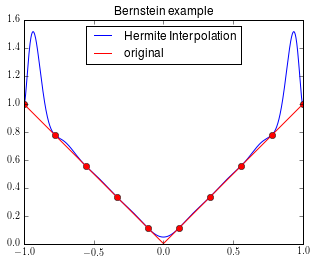

In [93]:
plt.figure()
plt.axes().set_aspect('equal')
plt.plot(x, interpolant(x), 'b', label='Hermite Interpolation')
plt.plot(nodes, np.abs(nodes), 'ro')
plt.plot(x, np.abs(x), 'r', label='original')
plt.legend(loc=9)
plt.title('Bernstein example')
plt.show()

#### Piecewise Polynomial Interpolation

By prescribing the degrees of several polynomial and a finite set of nodes, we can construct an interpolator that has on each subinterval between two consecutive nodes, a polynomial arc with the required order.  We can construct interpolants of this characteristic with the following procedures:

* A subclass of `_Interpolator1DWithDerivatives_`, `scipy.interpolate.PiecewisePolynomial`, with methods for evaluating interpolants and its derivatives, or appending new nodes.
* For the special case of piecewise linear interpolation, the utility `interp1d` creates an instance of the class `_Interpolator1D` with only the evaluation method.
* A function `scipy.interpolate.piecewise_polynomial_interpolate`: syntactic sugar for the class `PiecewisePolynomial`, with the evaluation method applied on a prescribed domain.  

Let us revisit the first example in this section.  First, we try piecewise linear interpolation with `interp1d`.  Second, we apply piecewise quadratic interpolation (all pieces have order 2) with the correct derivatives at every node, using `PiecewisePolynomial`.

[[ 0.     3.   ]
 [ 0.682  2.195]
 [ 0.997  0.212]
 [ 0.778 -1.885]
 [ 0.141 -2.97 ]]


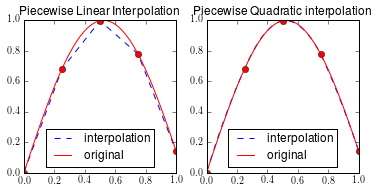

In [95]:
In [25]: from scipy.interpolate import PiecewisePolynomial

In [26]: nodes = np.linspace(0, 1, 5); \
   ....: x = np.linspace(0, 1, 100) 

In [27]: f = lambda t: np.sin(3 * t)

In [28]: interpolant = interp1d(nodes, f(nodes), kind='linear')

In [29]: plt.figure(); \
   ....: plt.subplot(121, aspect='equal'); \
   ....: plt.plot(x, interpolant(x), 'b--', label="interpolation"); \
   ....: plt.plot(nodes, f(nodes), 'ro'); \
   ....: plt.plot(x, f(x), 'r-', label="original"); \
   ....: plt.legend(loc=8); \
   ....: plt.title("Piecewise Linear Interpolation")

In [30]: yi = np.zeros((len(nodes), 2)); \
   ....: yi[:,0] = f(nodes); \
   ....: yi[:,1] = 3 * np.cos(3 * nodes); \
   ....: print yi

In [31]: interpolant = PiecewisePolynomial(nodes, yi, orders=2)

In [32]: plt.subplot(122, aspect='equal'); \
   ....: plt.plot(x, interpolant(x), 'b--', label="interpolation"); \
   ....: plt.plot(nodes, f(nodes), 'ro'); \
   ....: plt.plot(x, f(x), 'r-', label="original"); \
   ....: plt.legend(loc=8); \
   ....: plt.title("Piecewise Quadratic interpolation"); \
   ....: plt.show()

From this picture, the piecewise quadratic interpolation and the original function are virtually indistinguishable.  We need to go to computation of absolute values of differences (of the function together with its first and second derivatives) to actually realize the error of computation.  The following is a crude computation that approximates these errors, and illustrates the use of the method `.derivatives`:

In [97]:
In [33]: print np.abs(f(x) - interpolant(x)).max()

In [34]: f1prime = lambda t: 3 * np.cos(3 * t); \
   ....: print np.abs(f1prime(x) - interpolant.derivatives(x)).max()

In [35]: f2prime = lambda t: -9 * np.sin(3 * x); \
   ....: print np.abs(f2prime(x) - interpolant.derivatives(x,der=2)).max()

0.00933719300459
10.5892183859
9.99807730912


A great advantage of piecewise polynomial approximation is the flexibility of using polynomials of different degrees on different subintervals.  For instance, with the same set of nodes we can use lines in the first and last subintervals, and cubics for the others:

In [98]:
interpolant = PiecewisePolynomial(nodes, yi, orders=[1,3,3,1])

The other great advantage of the implementation of this interpolation scheme is the ease with which we may add new nodes, without the need to recalculate from scratch.  For example, to add a new node after the last one, we issue

In [99]:
interpolant.append(1.25, np.array([f(1.25)]))

#### Spline Interpolation

*Univariate Splines* are a special case of piecewise polynomials.  They possess a high degree of smoothness at the places where the polynomial pieces connect.  These functions can be written as linear combinations of basic splines with minimal support with respect to a given degree, smoothness, and set of nodes.

Univariate spline interpolations using splines of order up to five may be carried by the function `interp1d` with the appropriate `kind` option.  This function creates instances of `_Interpolator1DWithDerivatives`, with the corresponding class methods.  The computations are performed through calls to routines in the `Fortran` library `FITPACK`.  The following example shows the different possibilities:

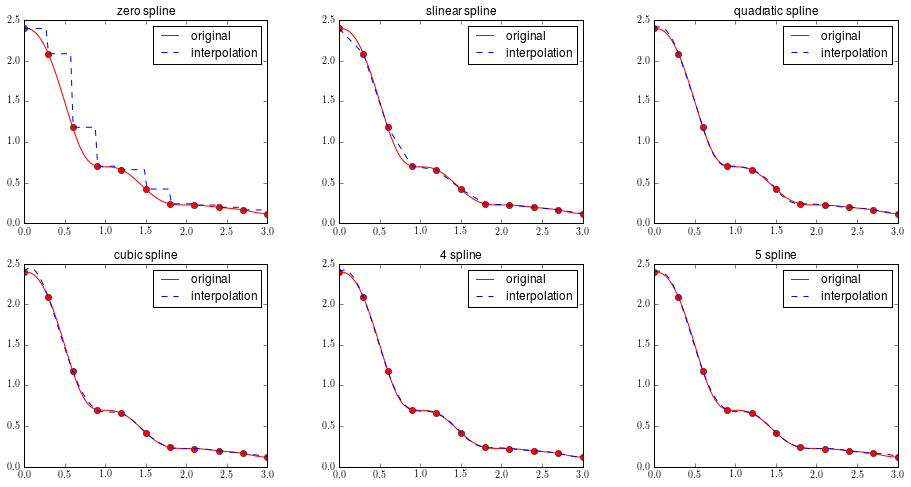

In [103]:
In [38]: splines = ['zero', 'slinear', 'quadratic', 'cubic', 4, 5]; \
   ....: g = KroghInterpolator([0,0,0,1,1,1,2,2,2,3,3,3], \
   ....:                       [10,0,0,1,0,0,0.25,0,0,0.125,0,0]); \
   ....: f = lambda t: np.log1p(g(t)); \
   ....: x = np.linspace(0,3,100); \
   ....: nodes = np.linspace(0,3,11)

In [39]: plt.figure(figsize=(16,8))

In [40]: for k in xrange(6):
   ....:     interpolant = interp1d(nodes, f(nodes), kind = splines[k]) 
   ....:     plt.subplot(2,3,k+1, aspect='equal')
   ....:     plt.plot(nodes, f(nodes), 'ro')
   ....:     plt.plot(x, f(x), 'r-', label='original')
   ....:     plt.plot(x, interpolant(x), 'b--', label='interpolation')
   ....:     plt.title('{0} spline'.format(splines[k]))
   ....:     plt.legend()

In [41]: plt.show()

> The zero spline is very similar to nearest-neighbor approximation, although in this case the interpolant is constant between each choice of two consecutive nodes.  The `slinear` spline is exactly the same as the piecewise linear interpolation.  The algorithm that performs this interpolation through splines is slower, though.

For any given problem set-up there are many different possible spline interpolations with the same degrees, nodes and evaluations.  The output also depends on the position and the number of knots, for example.  Unfortunately, the function `interp1d` does only allow the control of nodes and values: the algorithm uses the simplest possible settings in terms of knot computation. 

Note for instance that the cubic spline interpolation in the previous example does not preserve the monotonicity of the target function.  It is possible to force monotonicity of the interpolant in this case by carefully imposing restrictions on derivatives, or location of knots.  We have a special function that achieves this task for us, by using *piecewise monotonic cubic Hermite interpolation* (PCHIP), implemented through the Fritsch-Carlson algorithm.  This simple algorithm is carried either by the subclass `PchipInterpolator` of `_Interpolator1DWithDerivatives`, or through its equivalent procedural function, `pchip_interpolate`.


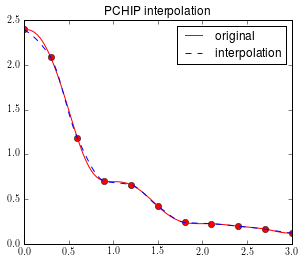

In [104]:
In [42]: from scipy.interpolate import PchipInterpolator

In [43]: interpolant = PchipInterpolator(nodes, f(nodes))

In [44]: plt.figure(); \
   ....: plt.axes().set_aspect('equal'); \
   ....: plt.plot(nodes, f(nodes), 'ro'); \
   ....: plt.plot(x, f(x), 'r-', label='original'); \
   ....: plt.plot(x, interpolant(x), 'b--', label='interpolation'); \
   ....: plt.title('PCHIP interpolation'); \
   ....: plt.legend(); \
   ....: plt.show()

Generic spline interpolation, where we have actual control over all the different parameters that affect the quality of splines, is handled by the class `InterpolatedUnivariateSpline`.  In this case, all computations are carried by wrappers of routines from the Fortran library `FITPACK`.  It is possible to access these wrappers in a procedural way, through a set of functions in the module `scipy.interpolate`. The following table shows a match between class methods, corresponding procedural functions, and the `FITPACK` routines they call.

| Operation | Object-oriented implementation | Procedural implementation | `FITPACK` routine |
|-----------|--------------------------------|---------------------------|-------------------|
| Instantiation of interpolant | `InterpolatedUnivariateSpline` | `splrep` | `CURFIT` |
| Reporting knots of spline | `object.get_knots()` | `splrep` ||
| Reporting spline coefficients | `object.get_coeffs()` | `splrep` | `CURFIT`|
| Evaluation of spline | `object()` | `splev` | `SPLEV`|
| Derivative | `object.derivative()` | `splder` | |
| Evaluation of derivatives | `object.derivatives()` | `splev`, `spalde` | `SPLDER`, `SPALDE`|
| Antiderivative | `object.antiderivative()` | `splantider` | |
| Definite integral | `object.integral()` | `splint` | `SPLINT` |
| Roots (for cubic splines) | `object.roots()` | `sproot` | `SPROOT`|

> The values obtained by the method `.get_coeffs` are the coefficients of the spline as a linear combination of B-splines.

Let us show how to approximate the area under the graph of the target function, by computing the integral of the corresponding interpolation spline of order 5.

In [105]:
In [45]: from scipy.interpolate import InterpolatedUnivariateSpline

In [46]: interpolant = InterpolatedUnivariateSpline(nodes, f(nodes), k=5)

In [47]: area = interpolant.integral(0,3); \
   ....: print area

2.14931665485
